# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#Using a custom datadir, because my jupyter notebook runs with a home dire mounted a NFS mount point
data_dir = '/data/datadir/dlnd-facegeneration-data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

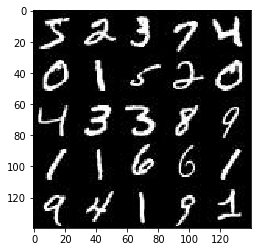

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

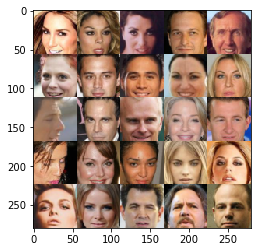

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 56, 56, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    #Real input shape: (batch_size, width, height, channels)
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    #z input shape: (batch_size, z_dim)
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Discriminator take as input 28x28xnum_channels
        #Shouldn't use batch normalization in the first discriminator conv layer
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                                 padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        #Leaky RELU
        conv1 =  tf.maximum(alpha * conv1, conv1)
        #Implement dropout with low drop_rate, discriminator only used in training, dropout always present
        conv1 = tf.nn.dropout(conv1, keep_prob=0.7)
        
        #14x14x64
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, 
                                 padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        #Batch norm
        #Discriminator is used only for training -> training always True
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        conv2 = tf.nn.dropout(conv2, keep_prob=0.7)
        
        #7x7x128
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=1, padding='same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        #Batch norm
        #Discriminator is used only for training -> training always True
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        conv3 = tf.nn.dropout(conv3, keep_prob=0.7,)
        
        #7x7*256
        #Flatten layer
        flat = tf.reshape(conv2, (-1, 7*7*256))
        #Logits and output
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #(not is_train): if it's train do not reuse variable if it's not reuse them
    with tf.variable_scope('generator', reuse=(not is_train)):
        #Fully connect and z connection to transpose conv pyramid
        #Land in 7x7x256
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        #Batch norm and LRELU
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        
        #Transpose convolution
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #Dropout only if it's train
        if is_train:
            x2 = tf.nn.dropout(x2, keep_prob=0.7)
        #Now (14,14,256)
        
        #Transpose convolution
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        x3= tf.layers.batch_normalization(x3, training=is_train)
        x3= tf.maximum(alpha * x3, x3)
        if is_train:
            x3 = tf.nn.dropout(x3, keep_prob=0.7)
        #Now (28,28,128)
        
        #Transpose convolution
        #Already in 28x28, strides must be 1
        x4 = tf.layers.conv2d_transpose(x3, 56, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        x4= tf.layers.batch_normalization(x4, training=is_train)
        x4= tf.maximum(alpha * x4, x4)
        if is_train:
            x4 = tf.nn.dropout(x4, keep_prob=0.7)
        
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Label smoothing
    real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
        # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    #data_shape[1:] beacuse model inputs doesn't expect batch size as input
    input_real, input_z, learn_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    if data_image_mode == 'L':
        out_channels_dim = 1
    else:
        out_channels_dim = 3
    d_loss, g_loss = model_loss(input_real, input_z, out_channels_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        steps = 0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                #Normalize input
                batch_images = batch_images * 2
                #Generate random unifrom z vector
                batch_z = np.random.uniform(-1 , 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate_tensor: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate_tensor: learning_rate})
                
                #Print stats
                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    
                if steps % 200 == 0:
                    show_generator_output(sess, 25, input_z, out_channels_dim, data_image_mode)
        saver.save(sess, './generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4939... Generator Loss: 3.1508
Epoch 1/2... Discriminator Loss: 0.4660... Generator Loss: 3.5054
Epoch 1/2... Discriminator Loss: 0.4325... Generator Loss: 3.4858
Epoch 1/2... Discriminator Loss: 0.4695... Generator Loss: 2.5347


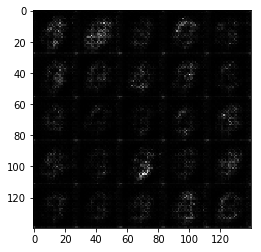

Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 4.0025
Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 3.4138
Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 3.4193
Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 3.6219


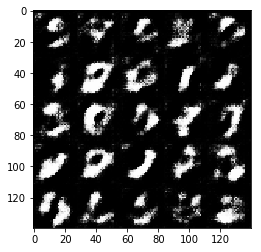

Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 3.3511
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 3.2603
Epoch 1/2... Discriminator Loss: 0.3975... Generator Loss: 3.7979
Epoch 1/2... Discriminator Loss: 0.3881... Generator Loss: 3.4010
Epoch 1/2... Discriminator Loss: 0.3889... Generator Loss: 3.7976
Epoch 1/2... Discriminator Loss: 0.3724... Generator Loss: 3.8398
Epoch 1/2... Discriminator Loss: 0.4182... Generator Loss: 3.1722
Epoch 1/2... Discriminator Loss: 0.3829... Generator Loss: 3.3860
Epoch 1/2... Discriminator Loss: 0.3838... Generator Loss: 3.2984
Epoch 2/2... Discriminator Loss: 0.3902... Generator Loss: 3.6468
Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 3.5100


In [ ]:
batch_size = 24
z_dim = 100
learning_rate = 0.0001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 3.4732
Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 3.7732
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 3.5985
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.3499


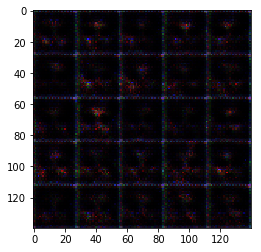

Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 4.2658
Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 4.6582
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 4.2336
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 4.4163


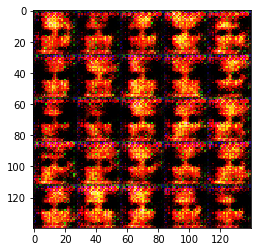

Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 4.7191
Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 4.7214
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 4.9313
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 4.1859


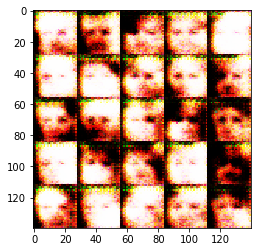

Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 4.8784
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 4.9250
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 4.8871
Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 4.7950


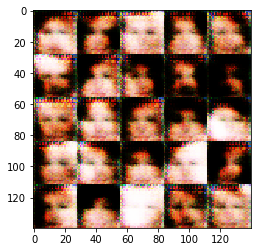

Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 5.1069
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 4.7741
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 4.1397
Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 4.7381


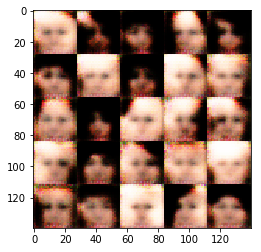

Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 4.2680
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 4.8381
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 4.3133
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 4.2268


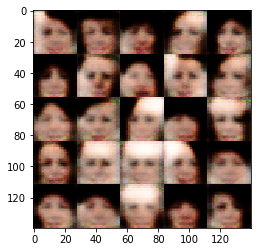

Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 3.8550
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 4.2855
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 4.4799
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 4.1929


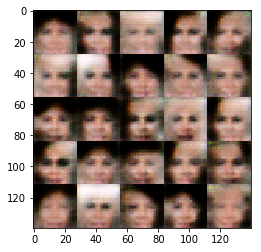

Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 4.3761
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 4.2524
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 4.1511
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 4.1483


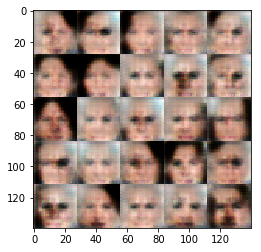

Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 3.8668
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 4.0040
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 3.2716
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 3.0917


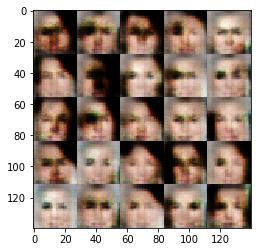

Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 3.5936
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 4.1301
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 3.1349
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 3.3711


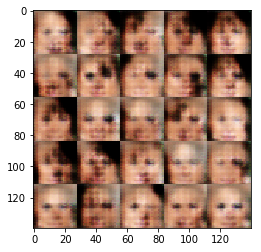

Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.9662
Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 4.0481
Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 3.5987
Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 3.4736


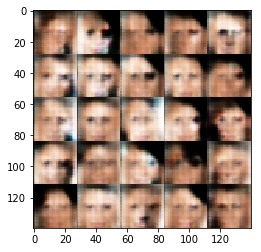

Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 3.9509
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 3.5656
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 3.5441
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.6259


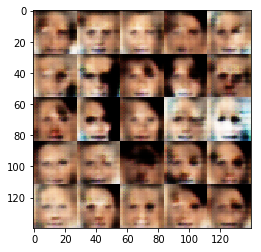

Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 3.7359
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 3.0190
Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 3.7886
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 3.1225


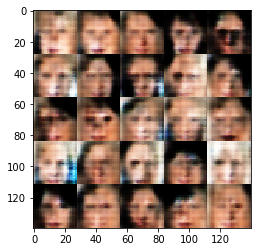

Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 3.0694
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 3.2217
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.2896
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 3.2227
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 3.0956
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 3.3336
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 2.9653


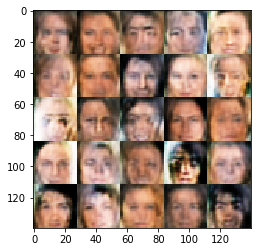

Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 3.6874
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.3933
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 3.0943
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 3.1937


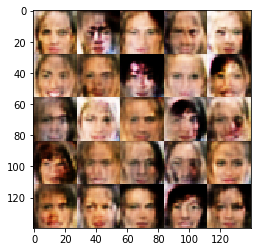

Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 3.2286
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 2.8167
Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 2.5743
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 3.0727


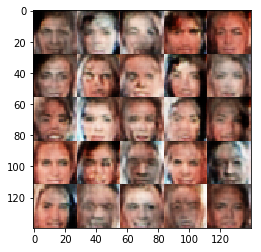

Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 3.0893
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 3.0064
Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 2.8954
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 3.1308


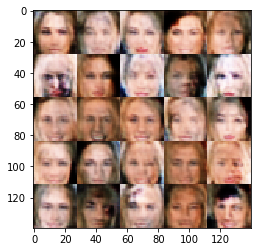

Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.2117
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 3.0562
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 3.0705
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 3.1064


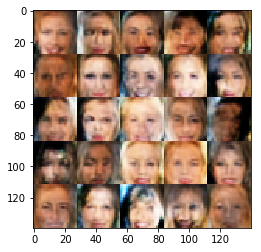

Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 2.9020
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 2.9555
Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 2.7217
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 2.9677


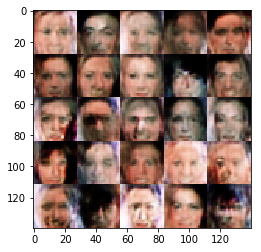

Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 2.8083
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 3.0126
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 2.9335
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 2.8080


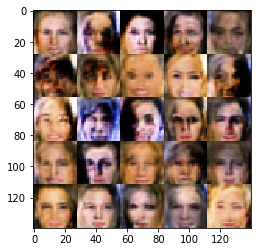

Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 2.9930
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 2.9897
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 2.8738
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 3.1609


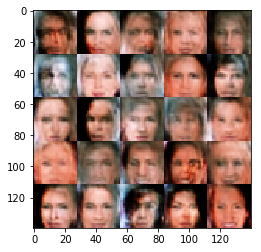

Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 3.0167
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 3.3007
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 3.0455
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 2.8973


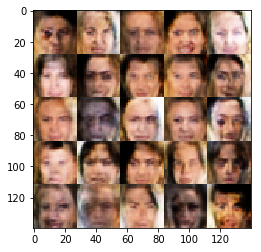

Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 3.2298
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 2.7442
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.0948
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 2.8310


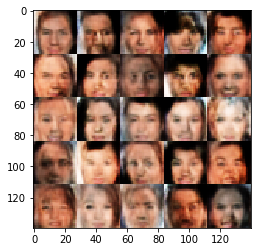

Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 2.8282
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 2.9825
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 2.9236
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 2.8886


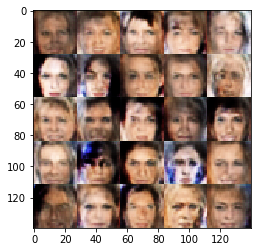

Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 2.9798
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 3.2116
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 2.8792
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.1531


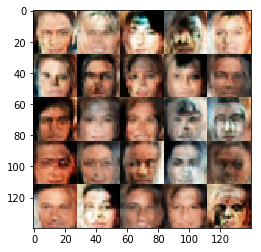

Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 3.2409
Epoch 1/1... Discriminator Loss: 0.4197... Generator Loss: 2.8994
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.0420
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 2.8953


In [ ]:
z_dim = 100
learning_rate = 0.0001
batch_size = 16
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.